In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
from torchvision import transforms, datasets, models
import torch.nn as nn
import copy
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

### Analyse the Brain Tumor Dataset

In [4]:
os.listdir("/kaggle/input/brain-tumor-mri-dataset")

['Training', 'Testing']

In [5]:
print("Testing Directories", os.listdir("/kaggle/input/brain-tumor-mri-dataset/Testing"))
print("Training Directories", os.listdir("/kaggle/input/brain-tumor-mri-dataset/Training"))

Testing Directories ['pituitary', 'notumor', 'meningioma', 'glioma']
Training Directories ['pituitary', 'notumor', 'meningioma', 'glioma']


##### From this we can see that there are 4 classes of brain tumor
1. Pituitary
2. No Tumor
3. Meningioma
4. Glioma

#### Lets us now analyse the Training directories

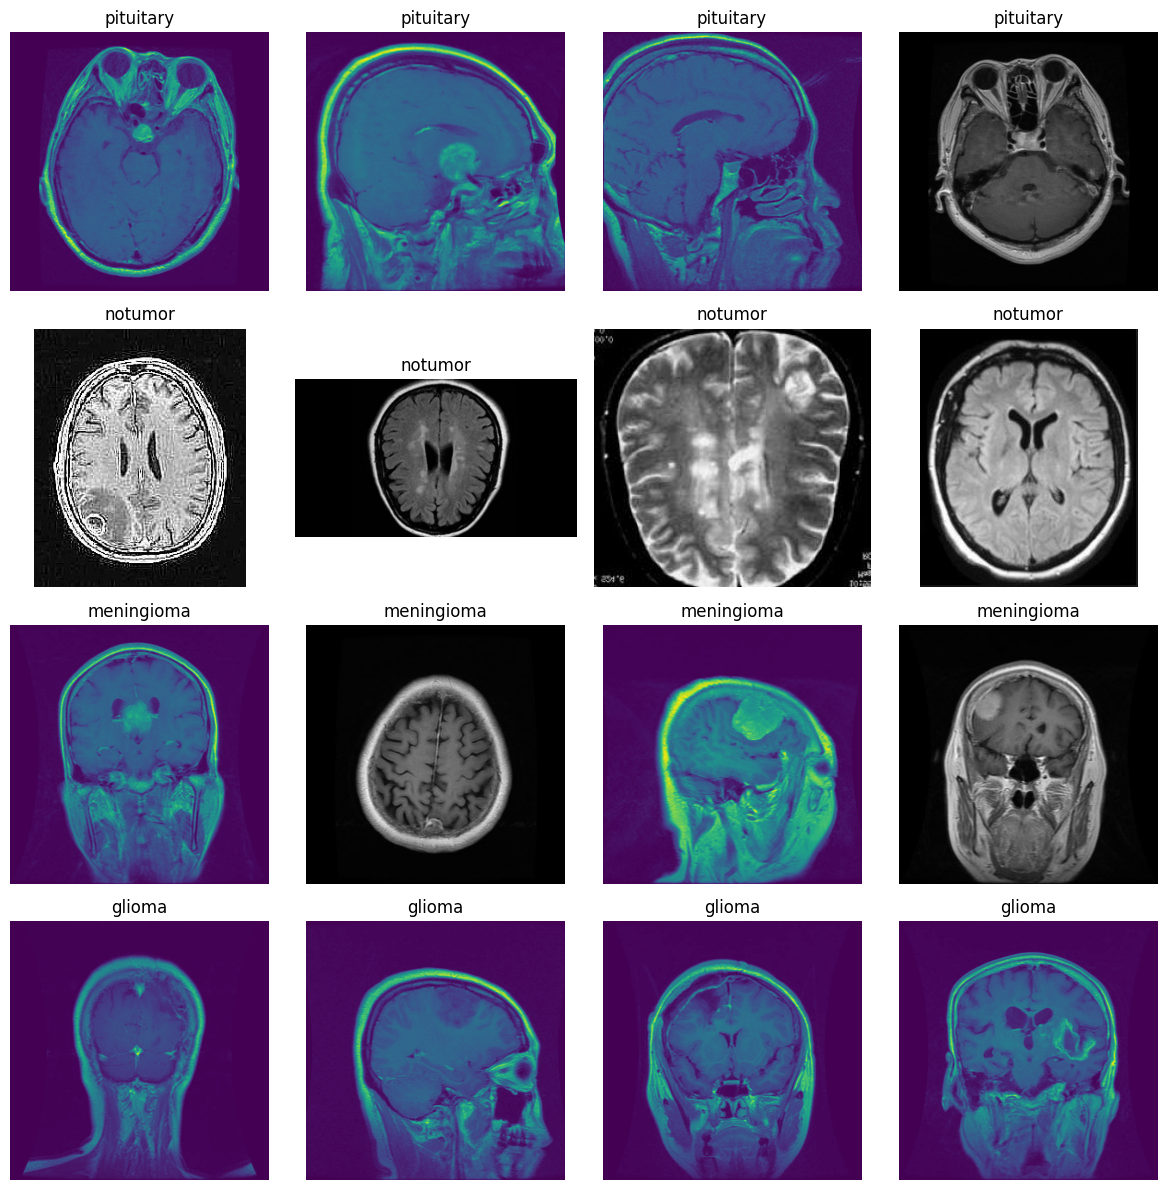

<Figure size 640x480 with 0 Axes>

In [6]:
classes = os.listdir("/kaggle/input/brain-tumor-mri-dataset/Training")

size = 4
fig, ax = plt.subplots(nrows=len(classes), ncols=size, figsize=(size * 3, len(classes) * 3))

if len(classes) == 1:
    ax = [ax]
if size == 1:
    ax = [[a] for a in ax]

for i,cl in enumerate(classes):
    directory = f"/kaggle/input/brain-tumor-mri-dataset/Training/{cl}"
    all_files = os.listdir(directory)
    random_files = random.sample(all_files, size)
    for j in range(size):
        img_path = os.path.join(directory, random_files[j])
        img = Image.open(img_path)
        ax[i][j].imshow(img)
        ax[i][j].axis('off')
        ax[i][j].set_title(cl)


plt.tight_layout()
plt.show()
plt.savefig('Analysis.png', dpi=300)

#### Image PreProcessing and Data Augementation

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]), 
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

data_transforms

{'train': Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     RandomHorizontalFlip(p=0.5)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 'val': Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 )}

In [9]:
directory = "/kaggle/input/brain-tumor-mri-dataset"

image_datasets = {
    'train': datasets.ImageFolder(root=f"{directory}/Training", transform=data_transforms['train']),
    'val': datasets.ImageFolder(root=f"{directory}/Testing", transform=data_transforms['val'])
}

image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 5712
     Root location: /kaggle/input/brain-tumor-mri-dataset/Training
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 1311
     Root location: /kaggle/input/brain-tumor-mri-dataset/Testing
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

#### Lets now create dataloaders, that will be fed into the Convolution NERUAL NETWORK

In [10]:
from torch.utils.data import DataLoader

dataloaders = {
    'train' : DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False)
}


### Loading ResNet18 Model Weights to perform Transfer Learning

In [11]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s] 


#### Architecture of RESNET-18

In [12]:
from torchinfo import summary 
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

### In the first part we will freeze all the layers and train only the last classifier part to perform classification and analyse the performance

In [13]:
### Freeze all layers of RESENT-18
for param in model.parameters():
    param.requires_grad = False

##### This is last Fully connected Layer before passing it to the softmax layers to classify 1000 classes

In [14]:
model.fc 

Linear(in_features=512, out_features=1000, bias=True)

In [15]:
class_names = os.listdir("/kaggle/input/brain-tumor-mri-dataset/Training")
num_classes = len(class_names)

##### Replace the last fully connected layer with our new layer to classify it into only 4 classes 

In [16]:
in_features = model.fc.in_features
print(f"The number of features into Last Fully Connected Layer is {in_features}")
model.fc = nn.Linear(in_features, num_classes)
model.fc

The number of features into Last Fully Connected Layer is 512


Linear(in_features=512, out_features=4, bias=True)

### Now our Last fully connected layer is ready to be trained alongwith pre-trained RESNET-18 layers

## Model Building

### Loss Function and Optimizer 

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [18]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_correct = 0

    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels =  labels.to(device)

        # Clears old gradients from the last backward pass
        optimizer.zero_grad()

        # Pass the images in the current batch to the model to get raw logits as 'outputs'
        outputs = model(imgs)

        # Pass the raw logits to the CrossEntropyLoss Function to determine the loss
        # CrossEntropyLoss internally applies Softmax and Negative log likelihood loss
        loss = criterion(outputs, labels)

        # Get Predicted class indices
        preds = torch.argmax(outputs, dim=1)

        # BackPropagation using Adam
        loss.backward()
        optimizer.step()

        running_loss += imgs.size(0) * loss.item()
        running_correct += torch.sum(preds == labels)


    train_loss = running_loss / len(dataloader.dataset)
    train_acc = running_correct.double() / len(dataloader.dataset)

    return train_loss, train_acc

In [19]:
def validate(model, dataloader, criterion, optimizer, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels =  labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            running_loss += imgs.size(0) * loss.item()
            running_correct += torch.sum(preds == labels)

    val_loss = running_loss / len(dataloader.dataset)
    val_acc = running_correct.double() / len(dataloader.dataset)

    return val_loss, val_acc

In [20]:
device

device(type='cuda')

In [21]:
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
EPOCHS = 5
model = model.to(device)

print("#------------ Model Training and validation -------------#")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
    val_loss, val_acc = validate(model, dataloaders['val'], criterion, optimizer, device)
    print(f"Epoch {epoch + 1} OF {EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    print("\n")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

print(f"Best accuracy: {best_acc}")
model.load_state_dict(best_model_wts)

#------------ Model Training and validation -------------#
Epoch 1 OF 5
Train Loss: 0.6547 Acc: 0.7768
Val   Loss: 0.5443 Acc: 0.8024


Epoch 2 OF 5
Train Loss: 0.4119 Acc: 0.8592
Val   Loss: 0.4385 Acc: 0.8299


Epoch 3 OF 5
Train Loss: 0.3586 Acc: 0.8752
Val   Loss: 0.4066 Acc: 0.8482


Epoch 4 OF 5
Train Loss: 0.3267 Acc: 0.8866
Val   Loss: 0.3733 Acc: 0.8528


Epoch 5 OF 5
Train Loss: 0.3066 Acc: 0.8883
Val   Loss: 0.3679 Acc: 0.8650


Best accuracy: 0.8649885583524027


<All keys matched successfully>

Accuracy: 0.8650
Precision (weighted): 0.8668
Recall (weighted): 0.8650
F1 Score (weighted): 0.8626

Classification Report:
               precision    recall  f1-score   support

   pituitary       0.95      0.77      0.85       300
     notumor       0.75      0.72      0.73       306
  meningioma       0.87      0.97      0.92       405
      glioma       0.91      0.97      0.94       300

    accuracy                           0.86      1311
   macro avg       0.87      0.86      0.86      1311
weighted avg       0.87      0.86      0.86      1311



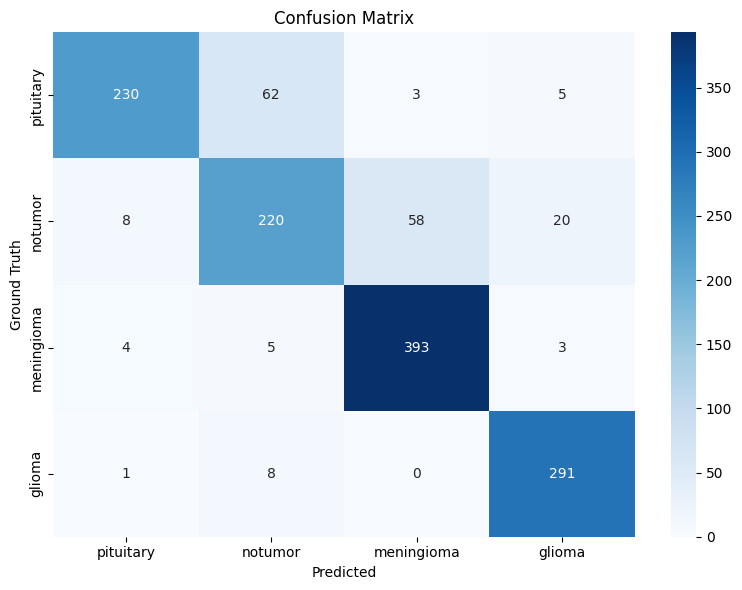

In [22]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in dataloaders['val']:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {acc:.4f}')
print(f'Precision (weighted): {precision:.4f}')
print(f'Recall (weighted): {recall:.4f}')
print(f'F1 Score (weighted): {f1:.4f}')
print('\nClassification Report:\n', classification_report(all_labels, all_preds, target_names=class_names))


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("Before_finetune.png", dpi=300)
plt.show()

#### Lets unfreeze layer4 and train it and try to see if we get a better performance

In [23]:
for name, param in model.named_parameters():
    print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [24]:
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(trainable_params, lr=0.0001)

In [25]:
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
EPOCHS = 5
model = model.to(device)

print("#------------ Model Training and validation -------------#")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
    val_loss, val_acc = validate(model, dataloaders['val'], criterion, optimizer, device)
    print(f"Epoch {epoch + 1} OF {EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    print("\n")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

print(f"Best accuracy: {best_acc}")
model.load_state_dict(best_model_wts)

#------------ Model Training and validation -------------#
Epoch 1 OF 5
Train Loss: 0.1995 Acc: 0.9258
Val   Loss: 0.0843 Acc: 0.9672


Epoch 2 OF 5
Train Loss: 0.0569 Acc: 0.9816
Val   Loss: 0.0418 Acc: 0.9870


Epoch 3 OF 5
Train Loss: 0.0410 Acc: 0.9867
Val   Loss: 0.0438 Acc: 0.9855


Epoch 4 OF 5
Train Loss: 0.0220 Acc: 0.9937
Val   Loss: 0.0477 Acc: 0.9817


Epoch 5 OF 5
Train Loss: 0.0175 Acc: 0.9956
Val   Loss: 0.0455 Acc: 0.9855


Best accuracy: 0.9870327993897788


<All keys matched successfully>

Accuracy: 0.9870
Precision (weighted): 0.9870
Recall (weighted): 0.9870
F1 Score (weighted): 0.9870

Classification Report:
               precision    recall  f1-score   support

   pituitary       0.99      0.98      0.98       300
     notumor       0.98      0.96      0.97       306
  meningioma       0.99      1.00      0.99       405
      glioma       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



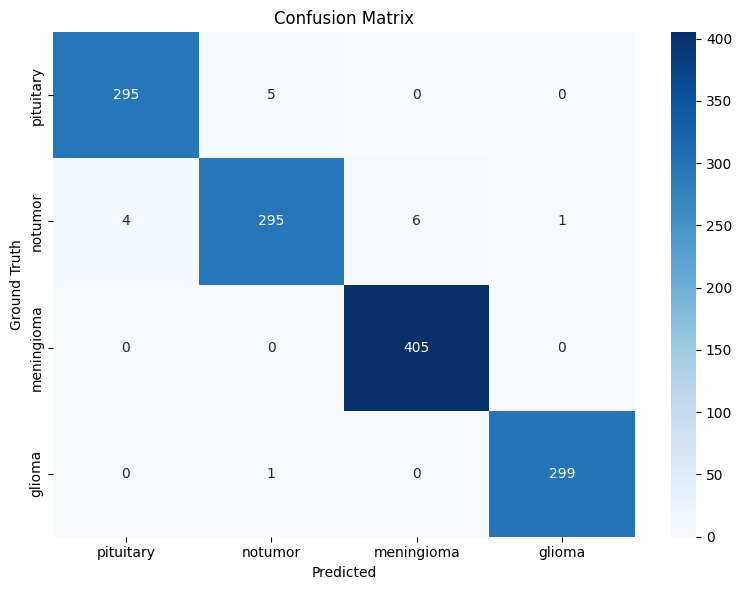

In [26]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in dataloaders['val']:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {acc:.4f}')
print(f'Precision (weighted): {precision:.4f}')
print(f'Recall (weighted): {recall:.4f}')
print(f'F1 Score (weighted): {f1:.4f}')
print('\nClassification Report:\n', classification_report(all_labels, all_preds, target_names=class_names))


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("After_finetune.png", dpi=300)
plt.show()

In [27]:
torch.save(model.state_dict(), 'resnet18-finetuned.pth')

In [28]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
# Variables to store activations and gradients
activations = []
gradients = []

# Forward hook to save activations (feature maps)
def save_activation(module, input, output):
    activations.append(output)

# Backward hook to save gradients
def save_gradient(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks
target_layer = model.layer4
target_layer.register_forward_hook(save_activation)
target_layer.register_full_backward_hook(save_gradient)

gradients.clear()
activations.clear()  


In [30]:
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image).unsqueeze(0)
    return image, input_tensor

In [31]:
import cv2

In [32]:
def gradcam(input_image):
    model.zero_grad() ## clear all gradients
    output = model(input_image)
    class_idx = torch.argmax(output).item()
    #print(class_idx)
    class_score = output[0, class_idx]
    #print(class_score) # tensor(9.9553, device='cuda:0', grad_fn=<SelectBackward0>)

    class_score.backward() # Computes gradients of this score w.r.t. feature maps in layer4

    target = activations[0].cpu().data.numpy()[0]  # Shape: [C, H, W]
    grads_val = gradients[0].cpu().data.numpy()[0] # Shape: [C, H, W]
    #  Gradients of class score w.r.t each channel in layer4's output
    
    #print(target.shape) # (512, 7, 7)
    #print(grads_val.shape) # (512, 7, 7)

    # next we compute the important weights (global avg pooling)
    # so for each channel we average the gradients over (H, W)
    weights = np.mean(grads_val, axis=(1,2))
    # gives a single value weight for each channel.
    # it tells us how much does this channel influnece the target class prediction
    
    #print(weights.shape) # (512,)

    # weighted sum of feature maps
    cam = np.zeros(target.shape[1:], dtype=np.float32)
    #print(cam.shape) # (7, 7)
    #print(cam)
    #print("\n")
    for i, w in enumerate(weights):
        cam += w * target[i, :, :]

    #print(cam)
    cam = np.maximum(cam, 0) # relu
    #print(cam.shape) # (7, 7)
    cam = cv2.resize(cam, (224, 224)) # resize to original image size --> (224, 224)
    #print("\n")
    #print(cam)

    ## min max normalisation --> [0,1]
    cam -= np.min(cam)
    cam /= np.max(cam)

    return cam

In [33]:
original_image, input_tensor = preprocess_image("/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-glTr_0000.jpg")
input_tensor = input_tensor.to(device)
print(input_tensor.shape)
gradcam(input_tensor)

torch.Size([1, 3, 224, 224])


array([[0.13079473, 0.13079473, 0.13079473, ..., 0.10948376, 0.10948376,
        0.10948376],
       [0.13079473, 0.13079473, 0.13079473, ..., 0.10948376, 0.10948376,
        0.10948376],
       [0.13079473, 0.13079473, 0.13079473, ..., 0.10948376, 0.10948376,
        0.10948376],
       ...,
       [0.10710531, 0.10710531, 0.10710531, ..., 0.07103617, 0.07103617,
        0.07103617],
       [0.10710531, 0.10710531, 0.10710531, ..., 0.07103617, 0.07103617,
        0.07103617],
       [0.10710531, 0.10710531, 0.10710531, ..., 0.07103617, 0.07103617,
        0.07103617]], dtype=float32)

In [34]:
import shutil
import os

input_root = '/kaggle/input/brain-tumor-mri-dataset'
output_root = '/kaggle/working/gradam_outputs'
os.makedirs(output_root, exist_ok=True)
folders = ['Training', 'Testing']

for subfolder in folders:
    subfolder_input_path = os.path.join(input_root, subfolder)
    subfolder_output_path = os.path.join(output_root, subfolder)
    
    if os.path.exists(subfolder_output_path):
        shutil.rmtree(subfolder_output_path)
    os.makedirs(subfolder_output_path, exist_ok=True)
    
    for class_folder in os.listdir(subfolder_input_path):
        class_input_dir = os.path.join(subfolder_input_path, class_folder)
        class_output_dir = os.path.join(subfolder_output_path, class_folder)

        if os.path.exists(class_output_dir):
            shutil.rmtree(class_output_dir)
        os.makedirs(class_output_dir, exist_ok=True)

        for img_name in os.listdir(class_input_dir):
            img_path = os.path.join(class_input_dir, img_name)
            original_image, input_tensor = preprocess_image(img_path)

            gradients.clear()
            activations.clear()
            input_tensor = input_tensor.to(device)
            cam = gradcam(input_tensor)

            heatmap_path = os.path.join(class_output_dir, f"{img_name.split('.')[0]}_heatmap.png")
            mask_path = os.path.join(class_output_dir, f"{img_name.split('.')[0]}_mask.png")

            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            cv2.imwrite(heatmap_path, heatmap)

            binary_mask = (cam > 0.5).astype(np.uint8) * 255
            cv2.imwrite(mask_path, binary_mask)



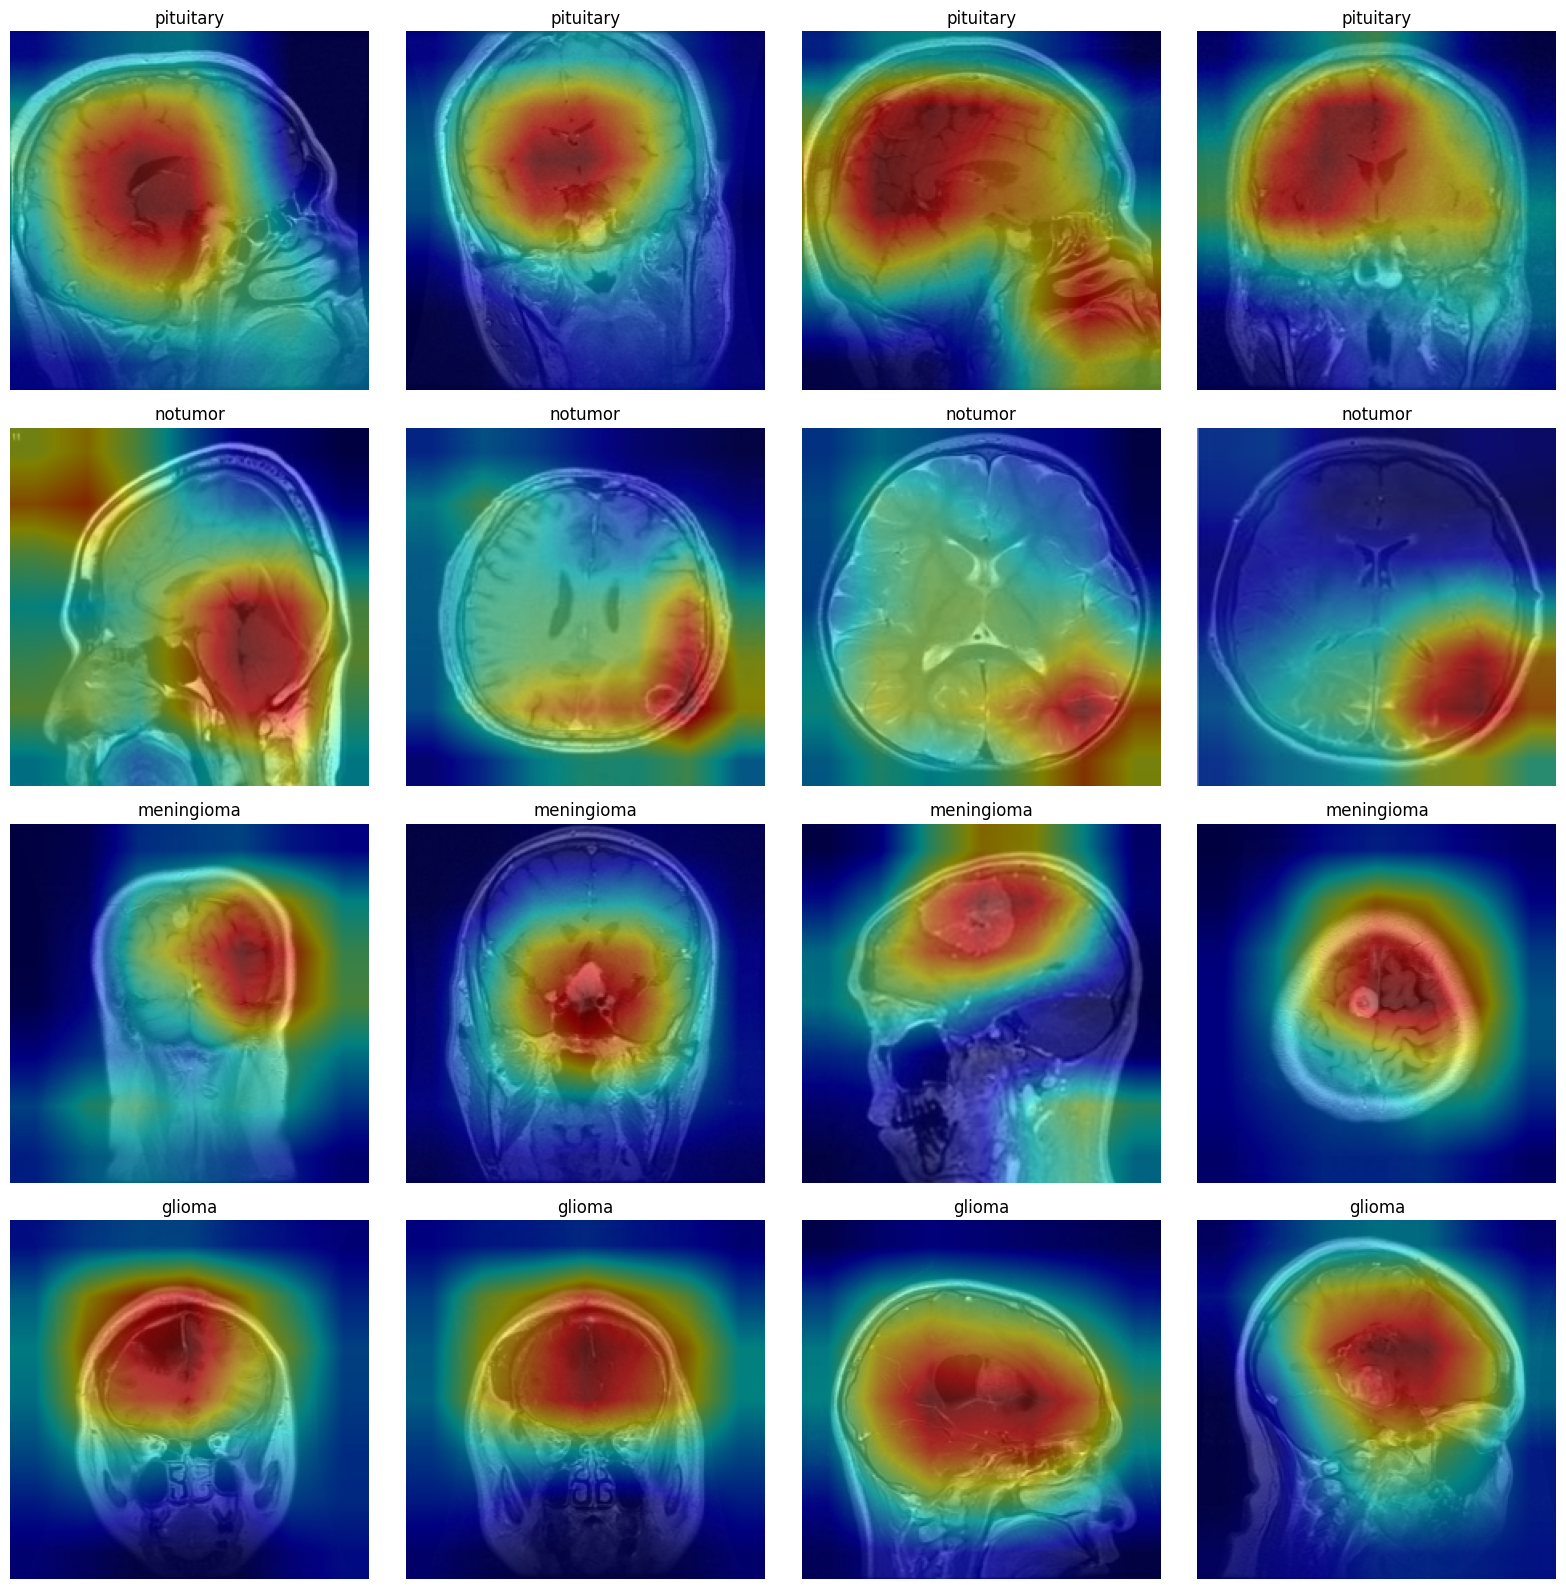

<Figure size 640x480 with 0 Axes>

In [35]:
gradcam_dir = "/kaggle/working/gradam_outputs/Training"
input_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"

SIZE = 4
alpha = 0.5
plt.figure(figsize=(SIZE * 4, 4 * 4))
img_idx = 1

for i, class_folder in enumerate(os.listdir(input_dir)):
    directory = f"{input_dir}/{class_folder}"
    all_files = os.listdir(directory)
    grad_directory = f"{gradcam_dir}/{class_folder}"
    random_files = random.sample(all_files, SIZE)
    heatmap_files = [f"{file.split('.')[0]}_heatmap.png" for file in random_files]

    for i, img in enumerate(random_files):
        img_path = os.path.join(directory, img)
        heatmap_path = os.path.join(grad_directory,heatmap_files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))

        heatmap = cv2.imread(heatmap_path)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = cv2.resize(heatmap, (224, 224))

        overlay = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

        plt.subplot(4, SIZE, img_idx)
        plt.imshow(overlay)
        plt.axis('off')
        plt.title(f"{class_folder}")
        img_idx += 1
        
plt.tight_layout()
plt.show()
plt.savefig('GRAD-CAM.png')

In [36]:
# dataset/
    # Training/
        # glioma/
    # Testing/
        # meningioma/

In [37]:
import os
import shutil

input_root = '/kaggle/working/gradam_outputs'
original_root = '/kaggle/input/brain-tumor-mri-dataset'
output_root = '/kaggle/working/unet-dataset'

images_dir = os.path.join(output_root, 'images')
masks_dir = os.path.join(output_root, 'masks')

os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

folders = ['Training', 'Testing']

for subfolder in folders:
    subfolder_mask_path = os.path.join(input_root, subfolder)
    subfolder_original_path = os.path.join(original_root, subfolder)

    for class_folder in os.listdir(subfolder_mask_path):
        mask_class_dir = os.path.join(subfolder_mask_path, class_folder)
        original_class_dir = os.path.join(subfolder_original_path, class_folder)

        for file in os.listdir(mask_class_dir):
            if file.endswith('_mask.png'):
                # Process Mask File
                mask_src = os.path.join(mask_class_dir, file)
                mask_dest_name = f"{file}"
                shutil.copy(mask_src, os.path.join(masks_dir, mask_dest_name))

                # Processing the corresponding original image
                original_file_name = file.replace('_mask.png', '.jpg')
                original_src = os.path.join(original_class_dir, original_file_name)

                if os.path.exists(original_src):
                    img_dest_name = f"{original_file_name}"
                    shutil.copy(original_src, os.path.join(images_dir, img_dest_name))
                else:
                    print(f"Image not found for mask: {file}")


In [38]:
# since we already performed randomHorizontalClip and other stuff, 
# we will just do resising and converting to tensor to ensure the same format is fed to the model
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


In [39]:
from torch.utils.data import Dataset, DataLoader

In [40]:
class TumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform 
        self.mask_transform = mask_transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = img_name.replace('.jpg', '_mask.png')

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if(image_transform):
            image = self.image_transform(image)
        if(mask_transform):
            mask = self.mask_transform(mask)

        mask = (mask > 0.5).float() 
        return image, mask

In [41]:
dataset = TumorDataset(
    image_dir='/kaggle/working/unet-dataset/images',
    mask_dir='/kaggle/working/unet-dataset/masks',
    image_transform=image_transform,
    mask_transform=mask_transform
)

In [42]:
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset, batch_size=8, shuffle=False)

In [43]:
for img, mask in val_loader:
    print(img.shape)
    break

torch.Size([8, 3, 128, 128])


In [44]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, pretrained_resnet):
        super(UNet, self).__init__()
        self.encoder_layers = list(pretrained_resnet.children())

        self.enc1 = nn.Sequential(*self.encoder_layers[:3])
        # conv2d, batchnorm, ReLU

        self.enc2 = nn.Sequential(*self.encoder_layers[3:5])
        # maxpool2d, layer1

        self.enc3 = self.encoder_layers[5] # layer2
        self.enc4 = self.encoder_layers[6] # layer3
        self.enc5 = self.encoder_layers[7] # layer4

        self.up4 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0)
        self.dec4 = self.conv_block(512, 256)

        self.up3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.dec3 = self.conv_block(256, 128)

        self.up2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0)
        self.dec2 = self.conv_block(128, 64)

        self.up1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0)
        self.dec1 = self.conv_block(64, 64)

        self.final_conv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


    def forward(self, x):
        # x ---> [3, 224, 224]
        e1 = self.enc1(x)
        # [64, 112, 112]
        e2 = self.enc2(e1)
        # [64, 56, 56]
        e3 = self.enc3(e2)
        # [128, 28, 28]
        e4 = self.enc4(e3) 
        # [256, 14, 14]
        e5 = self.enc5(e4) 
        # [512, 7, 7]

        d4 = self.up4(e5)
        # [256, 14, 14]
        # concate with e4 (skip connections)
        d4 = torch.cat([d4,e4], dim=1) 
        # [512, 14, 14]
        d4 = self.dec4(d4)
        # [256, 14, 14]

        d3 = self.up3(d4)
        # [128, 28, 28]
        # concate with e3 (skip connections)
        d3 = torch.cat([d3, e3], dim=1)
        # [256, 28, 28]
        d3 = self.dec3(d3)
        # [128, 28, 28]

        d2 = self.up2(d3)
        # [64, 56, 56]
        # concate with e2 (skip connections)
        d2 = torch.cat([d2, e2], dim=1)
        # [128, 56, 56]
        d2 = self.dec2(d2)
        # [64, 56, 56]

        d1 = self.up1(d2)
        # [64, 112, 112]
        d1 = self.dec1(d1)
        # [64, 112, 112]

        out = nn.functional.interpolate(d1, size=(128, 128), mode='bilinear', align_corners=False)

        # bilinear interpolation from 112,112 to 224,224
        out = self.final_conv(out)
        # [224, 224, 1]
        out = torch.sigmoid(out)
        # probabilities for each pixel
        return out
        

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model = UNet(pretrained_resnet = model).to(device)
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)

In [46]:
from torchinfo import summary
unet_model = UNet(pretrained_resnet = model).to(device)
summary(unet_model, input_size=(8, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [8, 1, 128, 128]          --
├─Sequential: 1-1                        [8, 64, 64, 64]           --
│    └─Conv2d: 2-1                       [8, 64, 64, 64]           (9,408)
│    └─BatchNorm2d: 2-2                  [8, 64, 64, 64]           (128)
│    └─ReLU: 2-3                         [8, 64, 64, 64]           --
├─Sequential: 1-2                        [8, 64, 32, 32]           --
│    └─MaxPool2d: 2-4                    [8, 64, 32, 32]           --
│    └─Sequential: 2-5                   [8, 64, 32, 32]           --
│    │    └─BasicBlock: 3-1              [8, 64, 32, 32]           (73,984)
│    │    └─BasicBlock: 3-2              [8, 64, 32, 32]           (73,984)
├─Sequential: 1-3                        [8, 128, 16, 16]          --
│    └─BasicBlock: 2-6                   [8, 128, 16, 16]          --
│    │    └─Conv2d: 3-3                  [8, 128, 16, 16]        

In [47]:
import torch.nn.functional as F

def dice_loss(pred, target, const=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    # pixel-wise intersection
    intersection = (pred * target).sum(dim=(2,3))

    # compute dice coefficient
    dice = (2.0 * intersection + const) / (pred.sum(dim = (2,3)) + target.sum(dim = (2,3)) + const)

    return 1 - dice.mean()
    # mean because we pass batches to the model so its better to take the mean

def combined_loss(pred, target):
    bce = F.binary_cross_entropy(pred, target)
    diceloss = dice_loss(pred, target)
    return bce + diceloss

In [48]:
EPOCHS = 20
for epoch in range(EPOCHS):
    unet_model.train()
    running_loss = 0.0 

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        
        outputs = unet_model(images)
        loss = combined_loss(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1} / {EPOCHS}], Training Loss: {avg_loss:.4f}")

    ### validation loop
    unet_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = unet_model(images)
            loss = combined_loss(outputs, masks)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch + 1} / {EPOCHS}], Validation Loss: {avg_val_loss:.4f}")
    print("\n")

Epoch [1 / 20], Training Loss: 1.3102
Epoch [1 / 20], Validation Loss: 1.3041


Epoch [2 / 20], Training Loss: 1.3022
Epoch [2 / 20], Validation Loss: 1.3016


Epoch [3 / 20], Training Loss: 1.2994
Epoch [3 / 20], Validation Loss: 1.2966


Epoch [4 / 20], Training Loss: 1.2972
Epoch [4 / 20], Validation Loss: 1.2927


Epoch [5 / 20], Training Loss: 1.2953
Epoch [5 / 20], Validation Loss: 1.2930


Epoch [6 / 20], Training Loss: 1.2935
Epoch [6 / 20], Validation Loss: 1.2912


Epoch [7 / 20], Training Loss: 1.2920
Epoch [7 / 20], Validation Loss: 1.2907


Epoch [8 / 20], Training Loss: 1.2905
Epoch [8 / 20], Validation Loss: 1.2881


Epoch [9 / 20], Training Loss: 1.2892
Epoch [9 / 20], Validation Loss: 1.2864


Epoch [10 / 20], Training Loss: 1.2881
Epoch [10 / 20], Validation Loss: 1.2867


Epoch [11 / 20], Training Loss: 1.2870
Epoch [11 / 20], Validation Loss: 1.2848


Epoch [12 / 20], Training Loss: 1.2859
Epoch [12 / 20], Validation Loss: 1.2855


Epoch [13 / 20], Training Loss: 1.

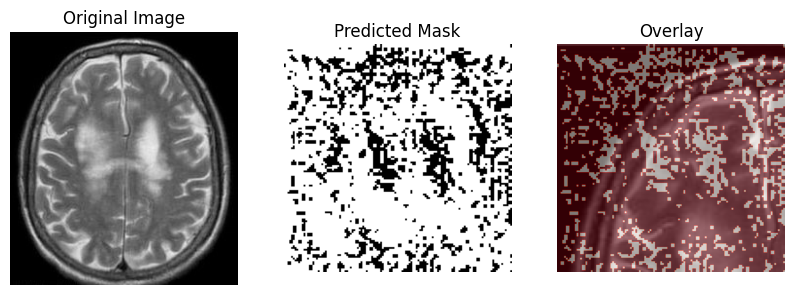

In [55]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def visualize_prediction(model, image_path, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    orig_image = image.copy()  
    input_image = image_transform(image).unsqueeze(0).to(device)  

    with torch.no_grad():
        pred_mask = model(input_image)
        pred_mask = pred_mask.squeeze().cpu() 
        pred_mask = (pred_mask > 0.5).float()  

    pred_mask_pil = TF.to_pil_image(pred_mask)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.title('Original Image')
    plt.imshow(orig_image)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.title('Predicted Mask')
    plt.imshow(pred_mask_pil, cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.title('Overlay')
    plt.imshow(orig_image)
    plt.imshow(pred_mask_pil, alpha=0.5, cmap='Reds') 
    plt.axis('off')
    plt.show()

visualize_prediction(unet_model, '/kaggle/working/unet-dataset/images/Tr-no_1173.jpg', device)
